In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_model import ZSTL

In [2]:
net = FuncRecursiveNet([
    FLinearLayer(1, False)
])

In [3]:
d = 8
dm = 5
T = 100
n = 10
dict_k = 6
shape_record = {}
shape_record[0] = [(1,d)]

np.random.seed(666)
L_gt = np.random.randn(d,dict_k)

D_gt = np.random.randn(dm,dict_k)

s_train = np.random.uniform(0, 2, size=(dict_k, T))
s_train[s_train>=1] = 0
#print(s_train)

s_kb = np.random.uniform(0, 2, size=(dict_k, 10))
s_kb[s_kb>=1] = 0
#print(s_val)
s_test = np.random.uniform(0, 2, size=(dict_k, T))
s_test[s_test>=1] = 0
#print(s_test)

w_train = L_gt @ s_train
w_kb = L_gt @ s_kb
w_test = L_gt @ s_test

a_train = D_gt @ s_train
a_kb = D_gt @ s_kb
a_test = D_gt @ s_test



ones = np.atleast_2d(np.ones(n))

x_kb = np.random.normal(0, 1.0, size=(d-1,n))
x_kb = np.vstack((ones, x_kb))

x_train = np.random.normal(0, 1.0, size=(d-1,n))
x_train = np.vstack((ones, x_train))


x_test = np.random.normal(0, 1.0, size=(d-1,n))
x_test = np.vstack((ones, x_test))

y_train = utils.sigmoid(w_train.T @ x_train)
y_train[y_train >=0.5] = 1
y_train[y_train <0.5] = 0

y_test = utils.sigmoid(w_test.T @x_test)
y_test[y_test >=0.5] = 1
y_test[y_test <0.5] = 0


y_kb = utils.sigmoid(w_kb.T @ x_kb)
y_kb[y_kb >=0.5] = 1
y_kb[y_kb <0.5] = 0

w_train = w_train.T
w_test = w_test.T
w_kb = w_kb.T
a_train = a_train.T
a_test = a_test.T
a_kb = a_kb.T
x_train = x_train.T
x_test = x_test.T
x_kb = x_kb.T

print('w_train ', w_train.shape)
print('w_test ', w_test.shape)
print('w_kb ', w_kb.shape)
print('a_train ', a_train.shape)
print('a_test ', a_test.shape)
print('a_kb ', a_kb.shape)
print('x_kb ', x_kb.shape)
print('x_train ', x_train.shape)
print('x_test ', x_test.shape)
print('y_train ', y_train.shape, np.sum(y_train, axis=1))
print('y_test ', y_test.shape)
print('y_kb ', y_kb.shape)

w_train  (100, 8)
w_test  (100, 8)
w_kb  (10, 8)
a_train  (100, 5)
a_test  (100, 5)
a_kb  (10, 5)
x_kb  (10, 8)
x_train  (10, 8)
x_test  (10, 8)
y_train  (100, 10) [7. 7. 5. 9. 7. 5. 6. 7. 7. 9. 8. 6. 6. 5. 4. 4. 8. 9. 9. 6. 9. 8. 6. 6.
 4. 6. 8. 7. 8. 7. 5. 3. 9. 6. 6. 8. 4. 6. 9. 7. 7. 9. 9. 5. 7. 3. 3. 6.
 7. 9. 8. 7. 9. 6. 9. 5. 9. 9. 8. 6. 6. 9. 5. 4. 9. 9. 9. 7. 7. 8. 8. 7.
 4. 9. 8. 9. 7. 7. 6. 6. 8. 9. 7. 7. 8. 6. 4. 8. 7. 8. 6. 7. 9. 7. 7. 7.
 8. 3. 9. 5.]
y_test  (100, 10)
y_kb  (10, 10)


In [4]:
kb_data = utils.Dataset([(a_kb[t,:], [w_kb[t,:]], x_kb, np.expand_dims(y_kb[t, :], axis=2)) for t in range(a_kb.shape[0])])

train_data = utils.Dataset([(a_train[t,:], [w_train[t,:]], x_train, np.expand_dims(y_train[t, :], axis=2)) for t in range(a_train.shape[0])])

test_data = utils.Dataset([(a_test[t,:], [w_test[t,:]], x_test, np.expand_dims(y_test[t, :], axis=2)) for t in range(a_test.shape[0])])

kb_loader = DataLoader(kb_data, batch_size=a_kb.shape[0], shuffle=False)
train_loader = DataLoader(train_data, batch_size=a_train.shape[0], shuffle=True)
test_loader = DataLoader(test_data, batch_size=a_test.shape[0], shuffle=True)

In [5]:
support_a, support_w, support_x, support_y = next(iter(kb_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
print(support_a.size(), support_w.size(), support_x.size(), support_y.size())

torch.Size([10, 1, 5]) torch.Size([10, 1, 8]) torch.Size([10, 10, 8]) torch.Size([10, 10, 1])


In [8]:
support_a, support_w, support_x, support_y = next(iter(kb_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)

param_dict = {}
param_dict['rho'] = 0.0001
param_dict['mu'] = 0.0001
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'


ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict)

5


init mean test loss 0.7929999999999998;
1/2000 o_loss 0.4710293365828693; mean test loss 0.7959999999999998 with mse loss in atten align 0.028056200593709946
50/2000 o_loss 0.4927491560205817; mean test loss 0.7719999999999999 with mse loss in atten align 0.0027594740968197584
100/2000 o_loss 0.48057390745729206; mean test loss 0.7380000000000002 with mse loss in atten align 0.0009399644914083183
150/2000 o_loss 0.4515315782278776; mean test loss 0.7550000000000003 with mse loss in atten align 0.000982548575848341
200/2000 o_loss 0.4328984730504453; mean test loss 0.7630000000000001 with mse loss in atten align 0.0010373906698077917
250/2000 o_loss 0.41707527104765174; mean test loss 0.7769999999999999 with mse loss in atten align 0.0011054136557504535
300/2000 o_loss 0.4015030033513904; mean test loss 0.7869999999999997 with mse loss in atten align 0.0011835081968456507
350/2000 o_loss 0.38557647753506896; mean test loss 0.7999999999999998 with mse loss in atten align 0.00127576140221

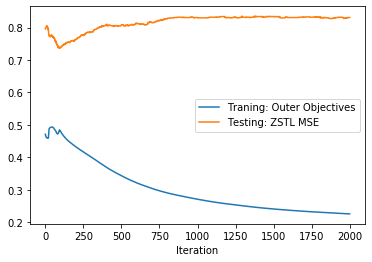

0

In [9]:
ZSTL_model.train(train_loader, test_loader, max_iter=2000)